

predict arrest outcome

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

In [11]:
#load data
df = pd.read_csv('data/cleaned_df.csv')

#change frisk and arrest flags to 1 and 0
df.replace({'Frisk_Flag' : { 'Y' : 1, 'N' : 0}}, inplace=True)
df.replace({'Arrest_Flag' : { 'Y' : 1, 'N' : 0}}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52147 entries, 0 to 52146
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject_Age_Group         52147 non-null  object
 1   Was_Weapon_Reported       52147 non-null  object
 2   Officer_Gender            52147 non-null  object
 3   Officer_Race              52147 non-null  object
 4   Subject_Perceived_Race    52147 non-null  object
 5   Subject_Perceived_Gender  52147 non-null  object
 6   Arrest_Flag               52147 non-null  int64 
 7   Frisk_Flag                52147 non-null  int64 
 8   Reported_Year             52147 non-null  int64 
 9   Officer_Age               52147 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 4.0+ MB


First the non-numeric variables need to be split into data types that can be properly interpreted by our machine learning models.

We drop the first of each of these dummies to reduce unneccessary correlation betweel features.

In [12]:
dummies_df = pd.get_dummies(df, drop_first=True)
dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52147 entries, 0 to 52146
Data columns (total 28 columns):
 #   Column                                                            Non-Null Count  Dtype
---  ------                                                            --------------  -----
 0   Arrest_Flag                                                       52147 non-null  int64
 1   Frisk_Flag                                                        52147 non-null  int64
 2   Reported_Year                                                     52147 non-null  int64
 3   Officer_Age                                                       52147 non-null  int64
 4   Subject_Age_Group_1 - 17                                          52147 non-null  uint8
 5   Subject_Age_Group_18 - 25                                         52147 non-null  uint8
 6   Subject_Age_Group_26 - 35                                         52147 non-null  uint8
 7   Subject_Age_Group_36 - 45                        

separate arrest outcome and train test split

In [13]:
X= dummies_df.drop('Arrest_Flag', axis=1)
y = dummies_df['Arrest_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(39110, 27)
(39110,)
(13037, 27)
(13037,)


talk about evaluation scores! list all, choose most important

scale numeric data before anything else

run through logreg model first

show auc score, roc (for true and false positives)

show confusion matrix

then identify class imbalance, use SMOTE to create synthetic data and try again


AUC: 0.6328889478833708


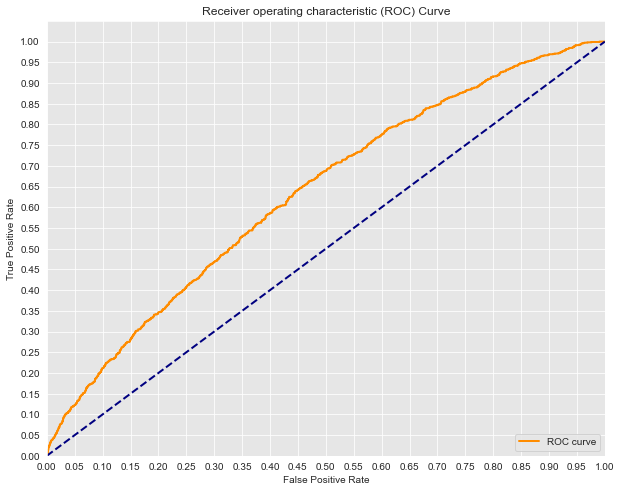

In [15]:
# Initial Model
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

C:\Users\moola\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


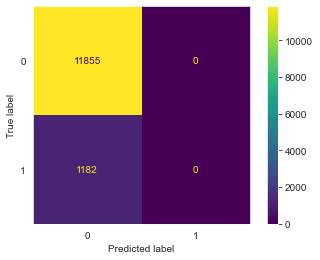

In [22]:
# Plot confusion matrix of the test set
plot_confusion_matrix(logreg, X_test, y_test)
plt.grid(False) # removes the annoying grid lines from plot
plt.show()

In [17]:
smote = SMOTE(random_state = 11)
X_train, y_train = smote.fit_resample(X_train, y_train)


after this observation, run multiple other models - pipeline with scaler and smote


we can further fine tune this model by adjust the parameters, using gridsearchcv

feature selection - lasso